In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error, 
    r2_score
)
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
X = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/X_USDINR.csv')
X.drop('Unnamed: 0', axis=1, inplace=True)
X.head()

,Deseasonalized_Day_high,Deseasonalized_Day_low,Deseasonalized_Open_price,EMA_50,EMA_100,EMA_200,RSI,MACD,Signal_Line,MACD_Histogram,SMA,Upper Band,Lower Band
0,0.002366,0.003777,0.002111,0.000000,0.000000,0.000000,0.0,0.435743,0.428316,0.501290,0.000988,0.000382,0.026881
1,0.002990,0.003444,0.005988,0.000148,0.000077,0.000040,0.0,0.440006,0.429330,0.511641,0.000988,0.000382,0.026881
2,0.000000,0.009943,0.006819,0.000310,0.000162,0.000085,0.0,0.443880,0.431063,0.518980,0.000988,0.000382,0.026881
3,0.000808,0.004527,0.006440,0.000284,0.000152,0.000080,0.0,0.441573,0.431901,0.509839,0.000988,0.000382,0.026881
4,0.003394,0.004238,0.001931,0.000529,0.000282,0.000148,0.0,0.447507,0.433982,0.522539,0.000988,0.000382,0.026881


In [3]:
y = pd.read_csv(r'C:/Users/uzmap/Documents/GitHub/ForEx/USDINR/Y_USDINR.csv')
y.drop('Unnamed: 0', axis=1, inplace=True)
y.head()

,Closing_price
0,61.400
1,61.495
2,61.508
3,61.391
4,61.565


In [11]:
print(y.columns)

Index(['Closing_price'], dtype='object')


In [12]:
y = y['Closing_price']

In [5]:
import numpy as np

def evaluate_trading_metrics(y_true, y_pred, initial_capital=1000):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Ensure lengths match
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Compute directional accuracy
    true_diff = np.sign(np.diff(y_true))
    pred_diff = np.sign(np.diff(y_pred))
    correct = np.sum(true_diff == pred_diff)
    trading_accuracy = correct / len(true_diff) * 100

    # Simulate trading strategy
    capital = [initial_capital]
    for i in range(1, len(y_pred)):
        # If model says price will go up -> buy (position = +1)
        # If model says price will go down -> short (position = -1)
        position = 1 if y_pred[i] > y_pred[i - 1] else -1
        profit = position * (y_true[i] - y_true[i - 1])
        capital.append(capital[-1] + profit)

    capital = np.array(capital)
    returns = np.diff(capital) / capital[:-1]

    # ROI
    roi = (capital[-1] - initial_capital) / initial_capital * 100

    # Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0

    # Max Drawdown
    peak = np.maximum.accumulate(capital)
    drawdown = (peak - capital) / peak
    max_drawdown = np.max(drawdown) * 100  # as a percentage

    return {
        "Trading Accuracy (%)": trading_accuracy,
        "ROI (%)": roi,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown (%)": max_drawdown
    }

In [4]:
def directional_accuracy(actual, predicted):
    # Ensure 1D arrays
    actual = np.ravel(actual)
    predicted = np.ravel(predicted)

    # Compute direction change
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare directions
    correct_direction = np.sign(actual_diff) == np.sign(pred_diff)

    return np.mean(correct_direction) * 100

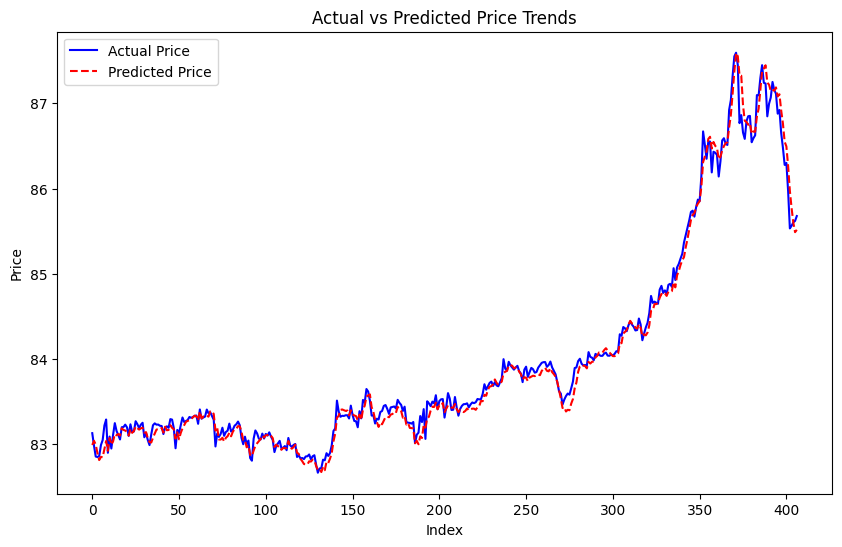

In [ ]:
def mlpRegressor_model(X,y): 
    # 85% train, 15% test
    total_size = len(X)
    train_end = int(total_size * 0.85)

    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:], y[train_end:]

    # Initialize the MLPRegressor (Neural Network model)

    mlp_model = MLPRegressor(hidden_layer_sizes=(150,), max_iter=2000, random_state=42,activation= 'relu')

    # Fit the model to the training data
    mlp_model.fit(X_train, y_train)

    # Predict the target values on the test data
    y_pred = mlp_model.predict(X_test)

    # Evaluate the model performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trading_metrics = evaluate_trading_metrics(y_test, y_pred)
    # Directional Accuracy
    dir_acc = directional_accuracy(y_test, y_pred)

    mlp_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)",
            "Directional Accuracy (%)"
        ],
        "Testing": [
            mae, 
            mse,
            mape * 100, 
            r2,
            dir_acc
        ]
    }
    mlp_metrics_df = pd.DataFrame(mlp_metrics)

    # Plot actual vs predicted trends
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(y_test)), y_test, label="Actual Price", color="blue")
    plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted Price Trends")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return mlp_metrics_df, trading_metrics

mlp_metrics_df, trading_metrics = mlpRegressor_model(X,y)

In [7]:
mlp_metrics_df

,Metric,Testing
0,Mean Absolute Error (MAE),0.076413
1,Mean Squared Error (MSE),0.011241
2,Mean Absolute Percentage Error (MAPE),0.090459
3,R-squared (R²),0.992511
4,Directional Accuracy (%),74.630542


In [ ]:
trading_metrics

{'Trading Accuracy (%)': 74.63054187192118,
 'ROI (%)': 2.4950999999999337,
 'Sharpe Ratio': 0.5906082062415774,
 'Max Drawdown (%)': 0.0315011010665147}

# Walk Forward Validation

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mlp_walk_forward_rolling(X, y, train_window=100, test_window=1):
    total_size = len(X)
    predictions = []
    actuals = []

    for start in range(0, total_size - train_window - test_window + 1):
        train_start = start
        train_end = start + train_window
        test_end = train_end + test_window

        X_train, y_train_window = X[train_start:train_end], y[train_start:train_end]
        X_test, y_test_window = X[train_end:test_end], y[train_end:test_end]

        model = MLPRegressor(hidden_layer_sizes=(150,), max_iter=2000, random_state=42, activation='relu')
        model.fit(X_train, y_train_window)

        y_pred_window = model.predict(X_test)

        predictions.extend(y_pred_window)
        actuals.extend(y_test_window)

    # Convert to NumPy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    dir_acc = directional_accuracy(actuals, predictions)

    trading_metrics = evaluate_trading_metrics(actuals, predictions)

    mlp_metrics = {
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)",
            "Directional Accuracy (%)"
        ],
        "Rolling Walk-Forward Testing": [
            mae, 
            mse,
            mape * 100, 
            r2,
            dir_acc
        ]
    }

    mlp_metrics_df = pd.DataFrame(mlp_metrics)

    # Plot (Zoomed)
    zoom_end = min(100, len(actuals))
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(zoom_end), actuals[:zoom_end], label="Actual Price", color="blue")
    plt.plot(np.arange(zoom_end), predictions[:zoom_end], label="Predicted Price", color="red", linestyle="dashed")
    plt.title("Zoomed: Actual vs Predicted Price Trends (MLP - Rolling WF)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return mlp_metrics_df, trading_metrics


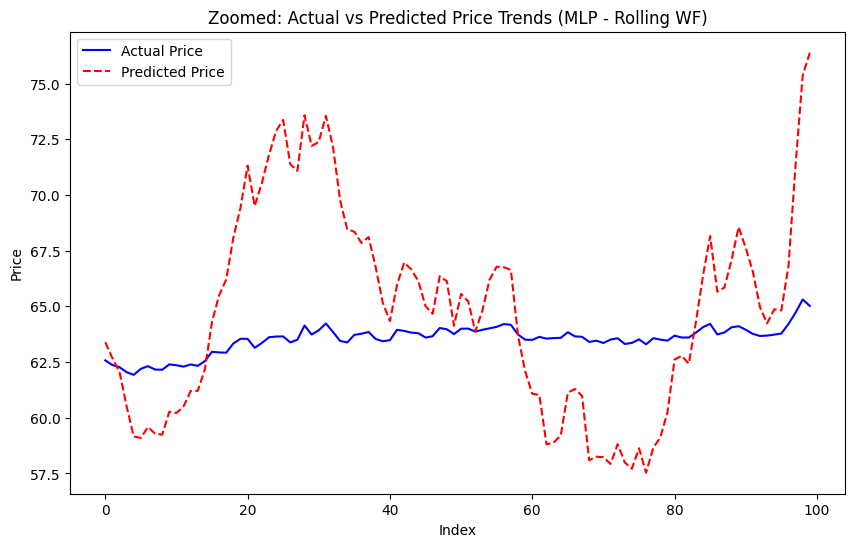

                                  Metric  Rolling Walk-Forward Testing
0              Mean Absolute Error (MAE)                      2.976647
1               Mean Squared Error (MSE)                     17.608262
2  Mean Absolute Percentage Error (MAPE)                      4.235414
3                         R-squared (R²)                      0.635207
4               Directional Accuracy (%)                     75.431200


In [13]:
mlp_metrics_df, trading_metrics = mlp_walk_forward_rolling(X, y, train_window=100, test_window=1)
print(mlp_metrics_df)

In [ ]:
trading_metrics

# Rolling Window Walk Forward

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# General rolling walk-forward function
def rolling_walk_forward_validation(X, y, model_fn, train_window=100, test_window=1, plot_zoom=100):
    total_size = len(X)
    predictions = []
    actuals = []

    for start in range(0, total_size - train_window - test_window + 1):
        train_start = start
        train_end = start + train_window
        test_end = train_end + test_window

        X_train, y_train_window = X[train_start:train_end], y[train_start:train_end]
        X_test, y_test_window = X[train_end:test_end], y[train_end:test_end]

        model = model_fn()
        model.fit(X_train, y_train_window)
        y_pred_window = model.predict(X_test)

        predictions.extend(y_pred_window)
        actuals.extend(y_test_window)

    # Convert to arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Compute metrics
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    dir_acc = directional_accuracy(actuals, predictions)

    # Evaluate trading-specific metrics if you have a function
    trading_metrics = evaluate_trading_metrics(actuals, predictions)

    results_df = pd.DataFrame({
        "Metric": [
            "Mean Absolute Error (MAE)", 
            "Mean Squared Error (MSE)",
            "Mean Absolute Percentage Error (MAPE)", 
            "R-squared (R²)",
            "Directional Accuracy (%)",
        ],
        "Rolling Walk-Forward Testing": [
            mae, 
            mse,
            mape * 100, 
            r2,
            dir_acc
        ]
    })

    # Plot zoomed window
    zoom_end = min(plot_zoom, len(actuals))
    plt.figure(figsize=(10, 6))
    plt.plot(actuals[:zoom_end], label="Actual", color="blue")
    plt.plot(predictions[:zoom_end], label="Predicted", color="red", linestyle="dashed")
    plt.title("Actual vs Predicted (Zoomed)")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    return results_df, trading_metrics

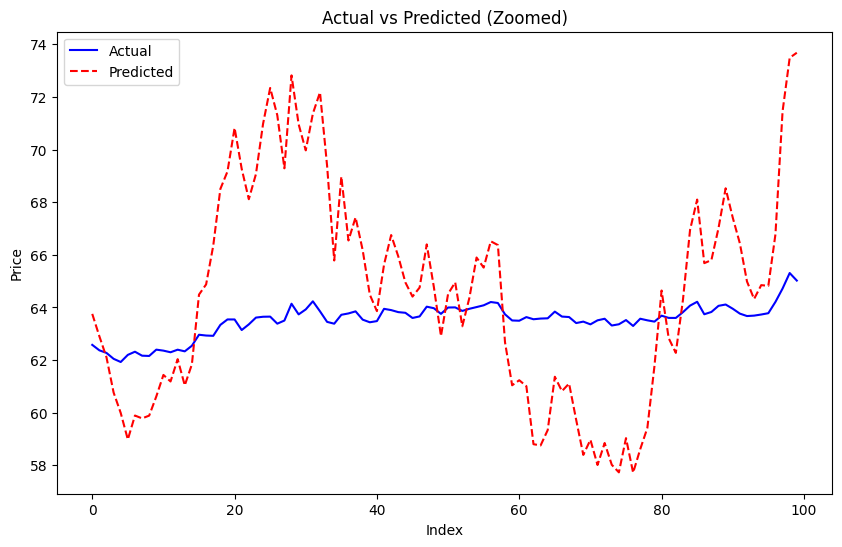

                                  Metric  Rolling Walk-Forward Testing
0              Mean Absolute Error (MAE)                      2.714224
1               Mean Squared Error (MSE)                     14.342202
2  Mean Absolute Percentage Error (MAPE)                      3.838641
3                         R-squared (R²)                      0.702870
4               Directional Accuracy (%)                     64.545803


In [15]:
# Define model factory
mlp_factory = lambda: MLPRegressor(hidden_layer_sizes=(150,), max_iter=2000, activation='relu')

# Run walk-forward validation
mlp_wf_metrics, trading_metrics = rolling_walk_forward_validation(
    X=X,
    y=y,
    model_fn=mlp_factory,
    train_window=100,
    test_window=1
)

print(mlp_wf_metrics)

In [16]:
trading_metrics

{'Trading Accuracy (%)': 64.54580298965121,
 'ROI (%)': 18.910580000000095,
 'Sharpe Ratio': 0.34023743295563913,
 'Max Drawdown (%)': 0.25756338931165035}